In [61]:
import matplotlib.pyplot as plt
import netCDF4
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [62]:
CMROOT = '/Users/axt5780/Library/CloudStorage/OneDrive-ThePennsylvaniaStateUniversity/PIML_project/IMERG_vectors/'
FILSTR = 'IMERG_vec_201801.nc'

nc = netCDF4.Dataset(os.path.join(CMROOT, FILSTR)) # reading the nc file and creating Dataset

In [63]:
nc.variables

{'time': <class 'netCDF4.Variable'>
 int64 time(time)
     units: minutes since 2018-01-01 00:00:00.000000
     calendar: julian
 unlimited dimensions: 
 current shape = (1488,)
 filling on, default _FillValue of -9223372036854775806 used,
 'idx': <class 'netCDF4.Variable'>
 int64 idx(idx)
 unlimited dimensions: 
 current shape = (39125,)
 filling on, default _FillValue of -9223372036854775806 used,
 'pmmhr': <class 'netCDF4.Variable'>
 float32 pmmhr(time, idx)
     _FillValue: nan
 unlimited dimensions: 
 current shape = (1488, 39125)
 filling on,
 'lat': <class 'netCDF4.Variable'>
 float32 lat(time, idx)
     _FillValue: nan
 unlimited dimensions: 
 current shape = (1488, 39125)
 filling on,
 'lon': <class 'netCDF4.Variable'>
 float32 lon(time, idx)
     _FillValue: nan
 unlimited dimensions: 
 current shape = (1488, 39125)
 filling on}

In [64]:
train, test = train_test_split(nc.variables['pmmhr'], test_size=0.2)

In [65]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [66]:
shape = test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(train, train,
          epochs=20,
          validation_data=(test, test),
          shuffle=True)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.2109 - val_loss: 0.0597
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0442 - val_loss: 0.0536
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0386 - val_loss: 0.0527
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0378 - val_loss: 0.0524
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0370 - val_loss: 0.0522
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0410 - val_loss: 0.0521
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0426 - val_loss: 0.0521
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0374 - val_loss: 0.0520
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0361 - val_loss: 0.0520
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0360 - val_loss: 0.0519
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0369 - val_loss: 0.0519
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - l

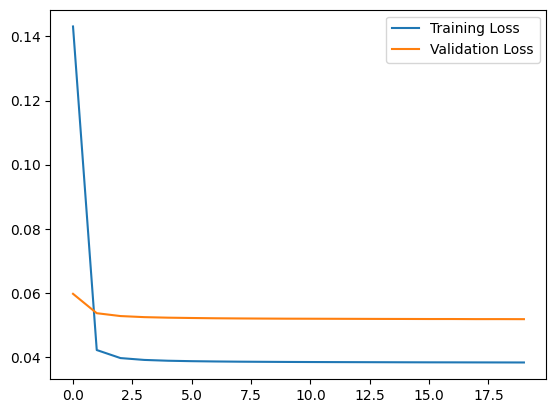

In [67]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [68]:
encoded = autoencoder.encoder(test).numpy()

In [69]:
encoded.shape

(298, 64)